# Comparison between analytic, Galerkin, hGalerkin, GalerkinNN & hGalerkinNN approximation for Bugers equation

In [1]:
%load_ext autoreload
%cd ../src

import numpy as np
import plotly.io as pio
import plotly.graph_objects as go
from scipy.integrate import quad
from scipy.special import erf
import matplotlib.pyplot as plt

from burgers_analytic import num_approx_burgers
from burgers_galerkin import num_approx_hermite_galerkin, hermit
from plot_utils import plot_sim_result

/home/etienne/Documents/Univ_Lille/M2/project_hGalerkinNN_for_CFD/code/src


In [2]:
# -------- initial profile x0 and its primitive G --------
def x0(z):
    """Initial condition x0(q)."""
    return  hermit(0,z)

def G(z):
    """Primitive of x0: G'(q) = x0(q).
    """
    return (np.pi**0.25 / np.sqrt(2)) * erf(z / np.sqrt(2))

# -------- parameters --------
hz   = 0.1      # spatial step
ht   = 0.05     # time step
Tmax = 5        # final time
n = 15          # dim sub vector space for galerkin projection

## True analytical solution & numerical approximation

### Change of explicit formulation for num. approx.

We start from the analytical solution
$$
x(t,z)
= -2\,\frac{\partial}{\partial z}
\ln\left[
\frac{1}{\sqrt{4\pi t}}
\int_{-\infty}^{+\infty}
\exp\left(
-\frac{(z-\sigma)^2}{4t}
-\frac12 G(\sigma)
\right)\,d\sigma
\right],
$$
where $G'(\sigma) = x_0(\sigma)$.

Defining
$$
F(t,z)
:= \frac{1}{\sqrt{4\pi t}}
\int_{-\infty}^{+\infty}
\exp\left(
-\frac{(z-\sigma)^2}{4t}
-\frac12 G(\sigma)
\right)\,d\sigma,
$$
so that
$$
x(t,z) = -2\,\frac{\partial_z F(t,z)}{F(t,z)}.
$$

#### Change of variable

Let
$$
\sigma = z + 2\sqrt{t}\,y,
\qquad d\sigma = 2\sqrt{t}\,dy.
$$
then
$$
\frac{(z-\sigma)^2}{4t}
= \frac{(z - (z+2\sqrt{t}y))^2}{4t}
= \frac{(2\sqrt{t}y)^2}{4t}
= y^2,
$$
and
$$
\frac{1}{\sqrt{4\pi t}}\,d\sigma
= \frac{1}{\sqrt{4\pi t}}\,(2\sqrt{t}\,dy)
= \frac{1}{\sqrt{\pi}}\,dy.
$$
so we get
$$
F(t,z)
= \frac{1}{\sqrt{\pi}}
\int_{-\infty}^{+\infty}
\exp\left(
- y^2
- \frac12 G(z+2\sqrt{t}\,y)
\right)\,dy.
$$

#### Differentiation wrt $z$

With differentiating in the integral,
$$
\partial_z F(t,z)
= \frac{1}{\sqrt{\pi}}
\int_{-\infty}^{+\infty}
\exp\left(
- y^2
- \frac12 G(z+2\sqrt{t}\,y)
\right)
\left(
-\frac12 G'(z+2\sqrt{t}\,y)
\right)\,dy.
$$
Since $G' = x_0$, we have
$$
\partial_z F(t,z)
= -\frac{1}{2\sqrt{\pi}}
\int_{-\infty}^{+\infty}
x_0(z+2\sqrt{t}\,y)
\exp\left(
- y^2
- \frac12 G(z+2\sqrt{t}\,y)
\right)\,dy.
$$

#### Final formula to numerically approximate $x(t,z)$

Replacing
$x(t,z) = -2\,\partial_z F / F$,
we get
$$
x(t,z)
=
\frac{
\displaystyle
\int_{-\infty}^{+\infty}
x_0(z+2\sqrt{t}\,y)\,
\exp\left(
- y^2
- \frac12 G(z+2\sqrt{t}\,y)
\right)\,dy
}{
\displaystyle
\int_{-\infty}^{+\infty}
\exp\left(
- y^2
- \frac12 G(z+2\sqrt{t}\,y)
\right)\,dy
}.
$$

This expression is numerically more stable, because the integration is always performed against the fixed Gaussian kernel
$\exp(-y^2)$ and no longer contains an explicit factor $1/t$ or a term $(z-\sigma)$.


### Numerical sim

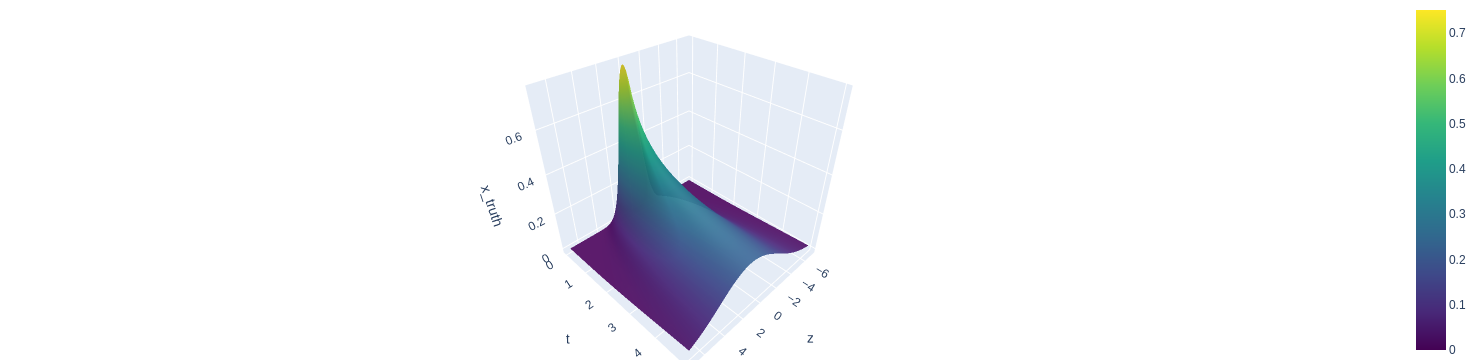

In [3]:
z_vals, t_vals, X_tr = num_approx_burgers(x0, G, hz, ht, Tmax)

# -------- interactive surface plot (Plotly) --------
plot_sim_result(z_vals, t_vals, X_tr, 'x_truth')

### Error eval of the numerical approx.

We consider the representation
$$
x(t,z)
=
\frac{
\displaystyle
\int_{\mathbb{R}} x_0(z+2\sqrt{t}\,y)\,
\exp\left(
- y^2
- \frac12 G(z+2\sqrt{t}\,y)
\right)\,dy
}{
\displaystyle
\int_{\mathbb{R}}
\exp\left(
- y^2
- \frac12 G(z+2\sqrt{t}\,y)
\right)\,dy
},
$$
with $G' = x_0$.

Defining
$$
w(y) := \exp\left(-y^2 - \tfrac12 G(z+2\sqrt{t}\,y)\right),\quad
N := \int_{\mathbb{R}} x_0(z+2\sqrt{t}\,y)\,w(y)\,dy,\quad
D := \int_{\mathbb{R}} w(y)\,dy,\quad
x = \frac{N}{D}.
$$

The code computes, on $[-L,L]$ and with numerical quadrature $Q$,
$$
\widehat N = Q[x_0(\cdot)\,w],\qquad
\widehat D = Q[w],\qquad
\widehat x = \frac{\widehat N}{\widehat D}.
$$

We want a bound on $|x - \widehat x|$.

---

#### 1. Truncation error ($|y|>L$)

Let
$$
N_L = \int_{-L}^{L} x_0(z+2\sqrt{t}\,y)\,w(y)\,dy,\qquad
D_L = \int_{-L}^{L} w(y)\,dy.
$$

Assume for example $|x_0(q)| \le 1$ and $0 \le G(q) \le 2$ (case $x_0(q)=\sin q$, $G(q)=1-\cos q$). Then
$$
e^{-y^2-1} \le w(y) \le e^{-y^2}.
$$
Hence
$$
|N - N_L|
\le \int_{|y|>L} |x_0|\,w
\le \int_{|y|>L} e^{-y^2}\,dy,
$$
$$
|D - D_L|
\le \int_{|y|>L} w
\le \int_{|y|>L} e^{-y^2}\,dy.
$$

For the Gaussian tail we have the standard bound
$$
\int_{|y|>L} e^{-y^2}\,dy
= \sqrt{\pi}\,\mathrm{erfc}(L)
\le \frac{1}{L} e^{-L^2}.
$$

So for $L=6$,
$$
\int_{|y|>6} e^{-y^2}\,dy
\lesssim \frac1{6} e^{-36} \approx 5 \times 10^{-17},
$$
which is an explicit upper bound for both $|N-N_L|$ and $|D-D_L|$.

---

#### 2. Quadrature error on $[-L,L]$

SciPy’s `quad` approximates
$$
N_L = \int_{-L}^{L} x_0(z+2\sqrt{t}\,y)\,w(y)\,dy,\qquad
D_L = \int_{-L}^{L} w(y)\,dy
$$
with an error controlled by the parameters `epsabs` and `epsrel`. Roughly,
$$
|Q[f] - \textstyle\int f|
\lesssim \texttt{epsabs} + \texttt{epsrel}\,\Big|\int f\Big|.
$$

Here:
- $\texttt{epsabs}$ is the **absolute tolerance**: a target upper bound for the absolute error, independent of the size of the integral,
- $\texttt{epsrel}$ is the **relative tolerance**: a target upper bound on the error *relative* to the magnitude of the integral.

In practice, for each integrand $f$ on $[-L,L]$,
$$
|Q[f] - \textstyle\int f|
\lesssim \texttt{epsabs} + \texttt{epsrel}\,\Big|\int f\Big|.
$$

Denote
$$
|N_L - \widehat N| \le \delta_N^{\text{quad}},\qquad
|D_L - \widehat D| \le \delta_D^{\text{quad}},
$$
where $\delta_{\bullet}^{\text{quad}}$ are **quadrature error bounds**. One can take:
- either the error estimates returned by `quad`,
- or safe bounds of the form
  $$
  \delta_N^{\text{quad}} \approx \texttt{epsabs} + \texttt{epsrel}\,|N_L|,\qquad
  \delta_D^{\text{quad}} \approx \texttt{epsabs} + \texttt{epsrel}\,|D_L|,
  $$
  using the computed values as proxies for $N_L$ and $D_L$.

Combine truncation + quadrature:
$$
|N - \widehat N|
\le |N - N_L| + |N_L - \widehat N|
\le \underbrace{\tfrac1L e^{-L^2}}_{\text{tail}}
   + \delta_N^{\text{quad}} =: \Delta_N,
$$
$$
|D - \widehat D|
\le \tfrac1L e^{-L^2} + \delta_D^{\text{quad}} =: \Delta_D.
$$

Thus $\Delta_N$ and $\Delta_D$ are **total error bounds** for $N$ and $D$, each combining:
- the truncation error from restricting to $[-L,L]$,
- and the quadrature error on $[-L,L]$ controlled by `epsabs`, `epsrel`.

---

#### 3. Propagation to the ratio

We have
$$
x - \widehat x
= \frac{N}{D} - \frac{\widehat N}{\widehat D}
= \frac{N\widehat D - \widehat N D}{D\widehat D}
= \frac{(N-\widehat N)\widehat D + \widehat N(\widehat D - D)}{D\widehat D}.
$$

Assuming $|D| \ge d_0 > 0$ and $|\widehat D| \ge d_0/2$ (true here since $w$ is comparable to a Gaussian), and also $|\widehat x| \le \sup |x_0|$ (for Burgers this holds), we obtain
$$
|x - \widehat x|
\le \frac{1}{|D\widehat D|}
\Big(|\widehat D|\,|N-\widehat N|
     + |D|\,|\widehat N|\,|D-\widehat D|/|\widehat D|\Big)
\lesssim \frac{2}{d_0}\,\Delta_N
       + \frac{2\sup|x_0|}{d_0}\,\Delta_D.
$$

In the sine example:

- $\sup |x_0| = 1$,
- $w(y) \ge e^{-y^2-1}$, so
  $$
  D \ge e^{-1} \int_{\mathbb{R}} e^{-y^2}\,dy = e^{-1}\sqrt{\pi},
  $$
  hence we can take $d_0 = e^{-1}\sqrt{\pi}/2$ as a safe lower bound for $|D|$ and $|\widehat D|$.

Thus, once $L$, `epsabs`, and `epsrel` are fixed, we have explicit bounds
$$
\Delta_N = \tfrac1L e^{-L^2} + \delta_N^{\text{quad}},\qquad
\Delta_D = \tfrac1L e^{-L^2} + \delta_D^{\text{quad}},
$$
and the ratio estimate above gives a concrete a priori bound on
$|x(t,z) - \widehat x(t,z)|$ for all $(t,z)$ in the grid.

Let:
- $L$ be the truncation radius in $y$ (integration on $[-L,L]$),
- $\delta_N,\delta_D$ be bounds for the quadrature errors on $[-L,L]$:
  $$
  |N_L - \widehat N| \le \delta_N,
  \qquad
  |D_L - \widehat D| \le \delta_D,
  $$
- $M = \sup_{q\in\mathbb{R}} |x_0(q)|$,
- $d_0 > 0$ such that $|D(t,z)| \ge d_0$ for all $(t,z)$ in the domain.

The truncation errors satisfy
$$
|N - N_L| \le \frac{1}{L} e^{-L^2},
\qquad
|D - D_L| \le \frac{1}{L} e^{-L^2}.
$$

Defining
$$
\Delta_N := \frac{1}{L} e^{-L^2} + \delta_N,
\qquad
\Delta_D := \frac{1}{L} e^{-L^2} + \delta_D,
$$
we see that $\delta_N$ and $\delta_D$ here play the same role as
$\delta_N^{\text{quad}}$ and $\delta_D^{\text{quad}}$ above: they are **quadrature error bounds** on $[-L,L]$.  
The sum
$$
\delta_N + \delta_D
$$
is simply the combined contribution of the numerator and denominator quadrature errors in the final bound.

Then a global bound on the error of the ratio is
$$
|x(t,z) - \widehat x(t,z)|
\;\le\;
\frac{2}{d_0}\Bigl(\Delta_N + M\,\Delta_D\Bigr).
$$

---

#### With $x_0(q) = \sin q$, $G(q) = 1 - \cos q$

In this case:
- $M = \sup |x_0| = 1$,
- one has $0 \le G(q) \le 2$, hence
  $$
  e^{-1}\sqrt{\pi}
  \;\le\;
  D(t,z)
  \;\le\;
  \sqrt{\pi},
  $$
  so we can take
  $$
  d_0 = \frac{1}{2} e^{-1} \sqrt{\pi}.
  $$

Plugging into the general bound gives
$$
|x(t,z) - \widehat x(t,z)|
\;\le\;
\frac{8e}{\sqrt{\pi}}\,
\frac{1}{L} e^{-L^2}
\;+\;
\frac{4e}{\sqrt{\pi}}\,
\bigl(\delta_N + \delta_D\bigr),
$$
uniformly in $(t,z)$ on the grid.


## Galerkin approximation

### Verification of galerkin projection of initial condition x0

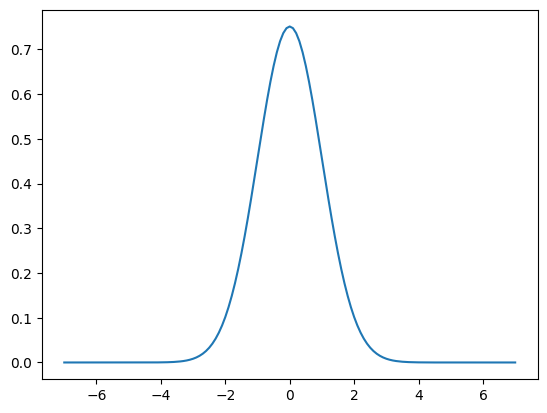

In [4]:
n = 15
z_vals = np.linspace(-7, 7, 141)

# compute only the initial coefficients
X0 = np.zeros(n)
for k in range(n):
    f = lambda y: x0(y) * hermit(k, y)
    X0[k], _ = quad(f, -np.inf, np.inf, limit=200)

# reconstruct at t = 0
X0_z = np.zeros_like(z_vals)
for j, z in enumerate(z_vals):
    X0_z[j] = sum(X0[k] * hermit(k, z) for k in range(n))

plt.plot(z_vals,X0_z)


### Simulation Galerkin

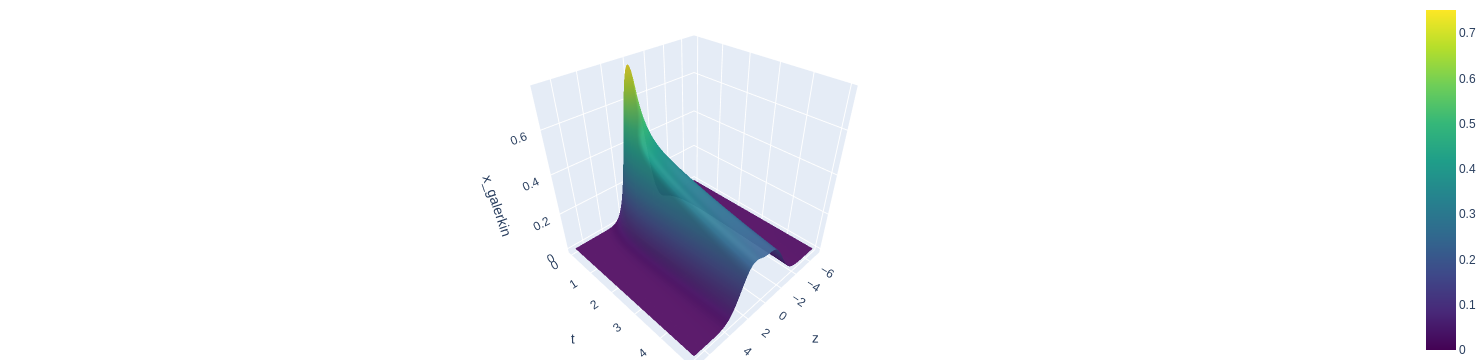

In [5]:
z_vals, t_vals, X_gal = num_approx_hermite_galerkin(x0, n, hz, ht, Tmax)

# interactive surface plot (x, t, M)
plot_sim_result(z_vals, t_vals, X_gal, 'x_galerkin')

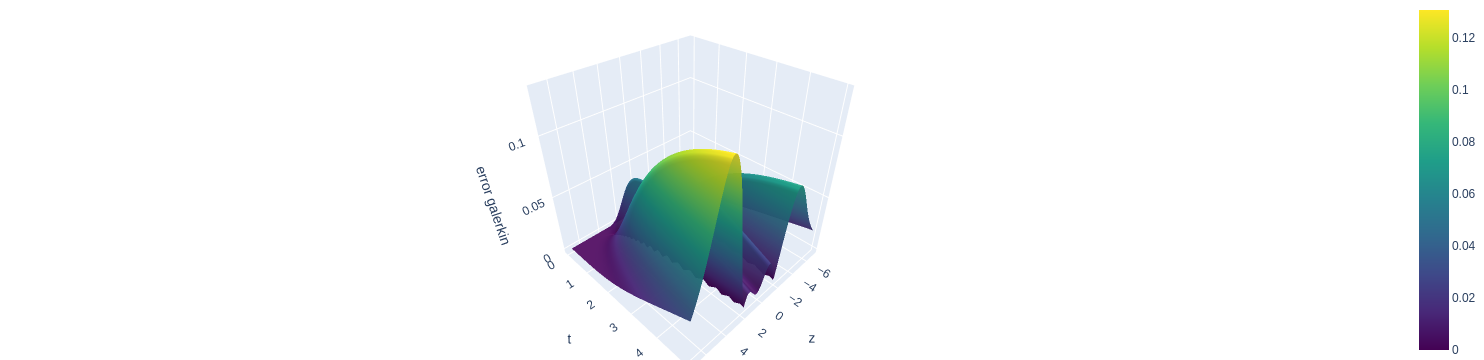

In [6]:
plot_sim_result(z_vals, t_vals, np.abs(X_tr-X_gal), 'error galerkin')